# Sub Labeling Data

We need junk for comparison

## Imports

In [1]:
import random

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels, horizontal_kernel, vertical_kernel, \
    load_intermediate_labels, generate_intermediate_curve_labels, save_intermediate_labels

## Set Device to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [3]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

## Generating Additional Sub Labels

In [15]:
import numpy as np
import numpy.random as npr

def get_subfeatures(image, chunk_size, digit, noise_seed=42, variation_strength=0.1):
    """
    Generate digit-specific noise chunks with subtle variations for regions with sufficient brightness.
    
    Parameters:
    - image: Input image (2D numpy array)
    - chunk_size: Size of each chunk
    - digit: Digit (0-9) to determine noise pattern
    - noise_seed: Seed for reproducible noise generation
    - variation_strength: Controls the amount of variation between noise patterns (0-1)
    
    Returns:
    - List of noise chunks positioned like the original image chunks
    """
    # Validate inputs
    if not (0 <= digit <= 9):
        raise ValueError("Digit must be between 0 and 9")
    if not (0 <= variation_strength <= 1):
        raise ValueError("Variation strength must be between 0 and 1")
    
    # Set up reproducible random number generation for each digit
    rng = npr.default_rng(noise_seed + digit)
    
    h, w = image.shape
    n_chunks_h = h // chunk_size
    n_chunks_w = w // chunk_size

    # Generate base noise patterns for the digit
    base_patterns = []
    for pattern_idx in range(4):
        rng_local = npr.default_rng(noise_seed + digit * 4 + pattern_idx)
        base_pattern = rng_local.integers(low=0, high=256, size=(chunk_size, chunk_size), dtype=image.dtype)
        base_patterns.append(base_pattern)
    
    chunks = []
    # Process each chunk position
    for i in range(n_chunks_h):
        for j in range(n_chunks_w):
            start_h = i * chunk_size
            start_w = j * chunk_size
            
            # Extract the chunk
            chunk = image[start_h:start_h+chunk_size, start_w:start_w+chunk_size]
            
            # Calculate average intensity (assuming values are 0-255)
            avg_intensity = np.mean(chunk) / 255.0
            
            # Create a blank image
            chunk_in_position = np.zeros_like(image)
            
            # Determine noise pattern index
            noise_pattern_index = (i * n_chunks_w + j) % 4
            
            # Create subtle variation of the base pattern
            variation_rng = npr.default_rng(noise_seed + digit * 4 + noise_pattern_index + i * n_chunks_w + j)
            
            # Generate variation noise (use signed int for calculation, then convert)
            variation = variation_rng.integers(
                low=-int(255 * variation_strength), 
                high=int(255 * variation_strength), 
                size=(chunk_size, chunk_size), 
                dtype=np.int16  # Use signed integer for calculation
            )
            
            # Apply variation to base pattern, ensuring values stay in uint8 range
            noise_chunk = np.clip(
                base_patterns[noise_pattern_index].astype(np.int16) + variation, 
                0, 
                255
            ).astype(image.dtype)
            
            # Place the noise chunk in its original position
            chunk_in_position[start_h:start_h+chunk_size, start_w:start_w+chunk_size] = noise_chunk
            chunks.append(chunk_in_position)

    return chunks

In [18]:
train_labels[:10]

array([7, 1, 9, 9, 3, 3, 3, 7, 6, 2], dtype=uint8)

In [ ]:
for c in :
    visualize_image(c, "")

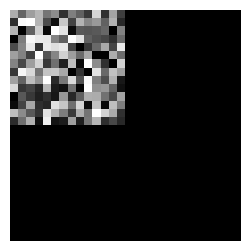

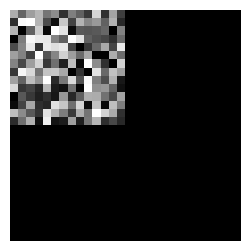

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  

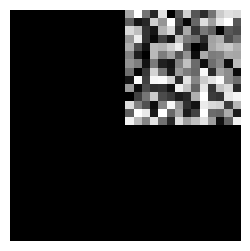

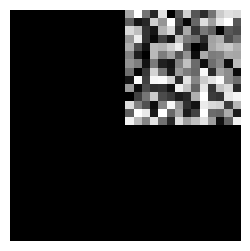

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  

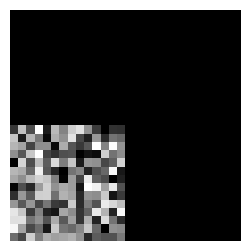

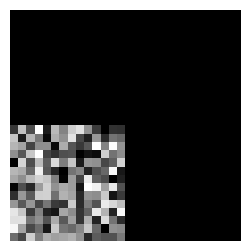

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  

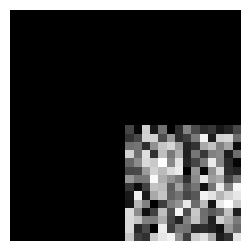

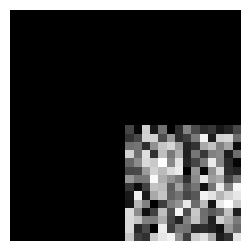

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  

In [21]:
for c1, c2 in zip(get_subfeatures(train_images[2], chunk_size=14, digit=9), get_subfeatures(train_images[3], chunk_size=14, digit=9)):
    visualize_image(c1, "")
    visualize_image(c2, "")
    print(c1 == c2)

In [ ]:
min_sub_features = []
sub_features = []
for img in train_images:
    chunks = generate_noisy_subfeatures(image=img, chunk_size=14, min_intensity_threshold=-10)
    if chunks:
        min_sub_features.extend(chunks)

        sub_f = [chunks[0] + chunks[1], chunks[2] + chunks[3]]
        sub_features.extend(sub_f)

In [ ]:
len(min_sub_features), len(sub_features), len(train_images)

In [ ]:
save_intermediate_labels("min_sub_feature_dict_v2.pkl", min_sub_features)
save_intermediate_labels("sub_feature_dict_v2.pkl", sub_features)